# Origin Data Take Home Assignment

by Giovanni da Costa Santin

## Step 1 - Loading libs

In [1]:
import numpy as np
import pandas as pd
from kmodes.kprototypes import KPrototypes
from plotnine import *
import plotnine

# Format scientific notation from Pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Step 2 - Loading and Cleansing Data

In [2]:
transactions = pd.read_csv('data/transactions.csv')
users = pd.read_csv('data/users.csv')

We'll now check the dimension on the data we'll be working on.

In [3]:
print("Dimension the data:\n")
print("Table Transactions: {} rows and {} columns.".format(transactions.shape[0], transactions.shape[1]))
print("Table Users: {} rows and {} columns.".format(users.shape[0], users.shape[1]))

Dimension the data:

Table Transactions: 11059 rows and 17 columns.
Table Users: 803 rows and 7 columns.


And see a taste of how is the data, for both tables.

In [4]:
transactions.head()

,_id,user_id,account_id,account_name,description,type,amount,date,extra_fields.category.0,extra_fields.category.1,extra_fields.category.2,extra_fields.category_id,extra_fields.merchant_name,extra_fields.name,extra_fields.payment_channel,extra_fields.payment_meta.payment_method,created_at
0,4D2119A1-03D9-48F2-99B7-FEDD80454431,94102846-0B6D-45D8-AFD1-DA80C54F6746,88F8D694-AFF0-4CFC-BBB6-C89D18059472,Chase - Plaid Money Market (4444),ACH Electronic CreditGUSTO PAY 123456,expense,-5850.000,2021-06-08T00:00:00.000Z,Transfer,Debit,NaN,21006000.000,NaN,ACH Electronic CreditGUSTO PAY 123456,other,ACH,2021-06-18T19:14:32.075Z
1,1A6F66DA-2E0F-435D-B10E-E9B5C5A37FE0,94102846-0B6D-45D8-AFD1-DA80C54F6746,88F8D694-AFF0-4CFC-BBB6-C89D18059472,Chase - Plaid Money Market (4444),ACH Electronic CreditGUSTO PAY 123456,expense,-5850.000,2021-05-09T00:00:00.000Z,Transfer,Debit,NaN,21006000.000,NaN,ACH Electronic CreditGUSTO PAY 123456,other,ACH,2021-06-18T19:14:32.075Z
2,99F0E0C2-A3CF-4293-87AC-EA2CD82EE3CB,94102846-0B6D-45D8-AFD1-DA80C54F6746,88F8D694-AFF0-4CFC-BBB6-C89D18059472,Chase - Plaid Money Market (4444),ACH Electronic CreditGUSTO PAY 123456,expense,-5850.000,2021-04-09T00:00:00.000Z,Transfer,Debit,NaN,21006000.000,NaN,ACH Electronic CreditGUSTO PAY 123456,other,ACH,2021-06-18T19:14:32.075Z
3,28D4C5D0-2DF1-4B9F-8895-109CE77DFAFA,94102846-0B6D-45D8-AFD1-DA80C54F6746,88F8D694-AFF0-4CFC-BBB6-C89D18059472,Chase - Plaid Money Market (4444),ACH Electronic CreditGUSTO PAY 123456,expense,-5850.000,2021-03-10T00:00:00.000Z,Transfer,Debit,NaN,21006000.000,NaN,ACH Electronic CreditGUSTO PAY 123456,other,ACH,2021-06-18T19:14:32.075Z
4,77223F04-ACBF-49C8-B101-DAD9B5F2E1A7,94102846-0B6D-45D8-AFD1-DA80C54F6746,88F8D694-AFF0-4CFC-BBB6-C89D18059472,Chase - Plaid Money Market (4444),ACH Electronic CreditGUSTO PAY 123456,expense,-5850.000,2021-02-08T00:00:00.000Z,Transfer,Debit,NaN,21006000.000,NaN,ACH Electronic CreditGUSTO PAY 123456,other,ACH,2021-06-18T19:14:32.075Z


In [5]:
users.head()

,id,created_at,date_of_birth,gender,country,state,city
0,131d8363-e2a6-4c60-acef-da03e6bfbdc4,2020-03-11 19:38:35,1990-08-16,male,US,CA,San Francisco
1,831216da-744b-48fd-b53f-35515ab96621,2020-05-01 13:09:00,1933-11-22,NaN,US,WA,Tonasket
2,ad7226ed-2d26-45fd-ab37-c3823cd5db0c,2020-03-11 13:45:27,1986-02-02,NaN,US,NY,New York
3,47f21175-1185-4fa3-b928-b2bfabcc42d5,2020-03-11 16:09:06,1990-01-01,male,US,CA,San Francisco
4,1029f5f6-04a3-486f-af2c-716d6b6006e2,2020-03-11 13:47:10,NaN,NaN,US,NaN,NaN


From inspecting the date, I found some state and city names with invalid that, so we'll proceed to cleanse those.

In [6]:
# First cleansing city column
users = users[users.city.str.replace(' ','').str.replace('.','').str.isalpha()==True]

# Then to the state column
users = users[users.state.str.isalpha()==True]

Then we'll see the types of data we're dealing with.

In [7]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11059 entries, 0 to 11058
Data columns (total 17 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   _id                                       11059 non-null  object 
 1   user_id                                   11059 non-null  object 
 2   account_id                                11059 non-null  object 
 3   account_name                              11059 non-null  object 
 4   description                               8317 non-null   object 
 5   type                                      11059 non-null  object 
 6   amount                                    11059 non-null  float64
 7   date                                      11059 non-null  object 
 8   extra_fields.category.0                   8317 non-null   object 
 9   extra_fields.category.1                   7874 non-null   object 
 10  extra_fields.category.2           

In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 624 entries, 0 to 802
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             624 non-null    object
 1   created_at     624 non-null    object
 2   date_of_birth  623 non-null    object
 3   gender         50 non-null     object
 4   country        624 non-null    object
 5   state          624 non-null    object
 6   city           624 non-null    object
dtypes: object(7)
memory usage: 39.0+ KB


All the data seems to be imported with the right data type. We'll have to deal with datetime columns, but we'll deal with that later on.

Now we'll check how many unique categories we have on the categorical part of this data.

In [9]:
transactions.select_dtypes('object').nunique()

_id                                         11059
user_id                                        84
account_id                                    118
account_name                                   95
description                                    15
type                                            3
date                                          547
extra_fields.category.0                         6
extra_fields.category.1                         9
extra_fields.category.2                         2
extra_fields.merchant_name                      9
extra_fields.name                              15
extra_fields.payment_channel                    2
extra_fields.payment_meta.payment_method        1
created_at                                    665
dtype: int64

In [10]:
users.select_dtypes('object').nunique()

id               624
created_at       624
date_of_birth    116
gender             4
country            1
state             28
city             120
dtype: int64

There's a total of 84 users on the transactions data, that's important because this is the entity we'll consider when training the model and our input table will be restricted to this number since we want the algorithm to group the users according to their buying patterns.

We'll ignore the id columns, since they do not bring any extra information to the analysis.

Now, we'll check how the transactions' amount is distributed.

In [11]:
# Calculating the percentage of missing data on each column for both datasets
transactions.isna().sum()/len(transactions)*100

_id                                         0.000
user_id                                     0.000
account_id                                  0.000
account_name                                0.000
description                                24.794
type                                        0.000
amount                                      0.000
date                                        0.000
extra_fields.category.0                    24.794
extra_fields.category.1                    28.800
extra_fields.category.2                    84.890
extra_fields.category_id                   24.794
extra_fields.merchant_name                 46.695
extra_fields.name                          24.794
extra_fields.payment_channel               24.794
extra_fields.payment_meta.payment_method   96.157
created_at                                  0.000
dtype: float64

In [12]:
users.isna().sum()/len(users)*100

id               0.000
created_at       0.000
date_of_birth    0.160
gender          91.987
country          0.000
state            0.000
city             0.000
dtype: float64

Inspecting the missing that, we'll have to eliminate the usage of all variables that have a large amount of missing data, since it is not recommended to try any sort of imputation on these cases.

On the table users, we'll get rid of `gender` variable, since it has 93% of unkknown data, we'll also eliminate the columns `extra_fields.payment_meta.payment_method`,  `extra_fields.merchant_name` and `extra_fields.category.2` from the transactions table, since they also have a high percentage of missing data.

In [13]:
users_dropped_columns = ['gender']
transactions_dropped_columns = ['extra_fields.payment_meta.payment_method', 'extra_fields.merchant_name', 'extra_fields.category.2']

In [14]:
users = users.copy().drop(users_dropped_columns, axis=1)
transactions = transactions.copy().drop(transactions_dropped_columns, axis=1)

In [15]:
# Transforming datetime fields in datetime format
## table users
users.date_of_birth = pd.to_datetime(users.date_of_birth, format='%Y-%m-%d', errors='coerce')
users.created_at = pd.to_datetime(users.created_at, format='%Y-%m-%d %H:%M:%S', errors='coerce')

## table transactions
transactions.created_at = pd.to_datetime(transactions.created_at)
transactions.date = pd.to_datetime(transactions.date)

In [16]:
#Calculating user age, considering a year to be 365.25 days
users['age'] = (users.created_at - users.date_of_birth).apply(lambda x: x.days).divide(365.25)

#Now we can drop created_at and date_of_birth columns
users = users.drop(['created_at', 'date_of_birth'], axis=1)

I observed that `user_id` column on the transactions table is capitalized, while on the users table it is not. So in order to join/merge both tables I lowered the entire string on the transactions table.

In [17]:
transactions.user_id = transactions.user_id.apply(lambda x: str.lower(x))

Lastly, the clustering algorithm we'll be using does not know how to deal with missing data. For the column `age` we'll be filling the missing data with the median. For the table transactions, since all the missing data we have is for categorical data, we'll simply substitute the missings for the "Not Informed" string, which will be considered a new category on each column.

In [18]:
users.age.fillna(users.age.median(), inplace=True)
transactions.fillna("Not Informed", inplace=True)

## Step 3 - Feature Engineering

As mentioned before, the basic element for our clustering algorithm will be user, so we'll also have to group the data on the transactions table to represent each user.

The first variables we'll create are recency, frequency and ammount considering the number of subgroups available.

In [19]:
df_to_calculate_recency = transactions.groupby('user_id')['date','created_at'].max()
df_to_calculate_recency['recency'] = (df_to_calculate_recency.created_at - df_to_calculate_recency.date).apply(lambda x: x.days)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [20]:
users = users.merge(df_to_calculate_recency.drop(['date','created_at'],axis=1), left_on='id', right_on='user_id')

# On this merge we lost four users, which weren't found on the transactions table

In [21]:
# Calculating frequencies per type of transaction
df_to_calculate_frequencies = transactions.groupby(['user_id', 'type'])['amount'].count().to_frame()
df_to_calculate_frequencies = df_to_calculate_frequencies.unstack().fillna(0)
df_to_calculate_frequencies.columns = df_to_calculate_frequencies.columns.get_level_values(1).str.lower().str.replace(' ', '_')
df_to_calculate_frequencies = df_to_calculate_frequencies.add_suffix('_frequency')

In [22]:
users = users.merge(df_to_calculate_frequencies, left_on='id', right_on='user_id')

In [23]:
# Calculating ammounts per type of transaction
df_to_calculate_total_ammount = transactions.groupby(['user_id', 'type'])['amount'].sum().to_frame()
df_to_calculate_total_ammount = df_to_calculate_total_ammount.unstack().fillna(0)
df_to_calculate_total_ammount.columns = df_to_calculate_total_ammount.columns.get_level_values(1).str.lower().str.replace(' ', '_')
df_to_calculate_total_ammount = df_to_calculate_total_ammount.add_suffix('_ammount')

In [24]:
users = users.merge(df_to_calculate_total_ammount, left_on='id', right_on='user_id')

In [25]:
# Calculating ammounts and frequencies per extra_fields.category.0 column
# First Frequencies
df_to_calculate_extra_field_freq = transactions.groupby(['user_id', 'extra_fields.category.0'])['amount'].count().to_frame()
df_to_calculate_extra_field_freq = df_to_calculate_extra_field_freq.unstack().fillna(0)
df_to_calculate_extra_field_freq.columns = df_to_calculate_extra_field_freq.columns.get_level_values(1).str.lower().str.replace(' ', '_')
df_to_calculate_extra_field_freq = df_to_calculate_extra_field_freq.add_suffix('_frequency')

# Then Ammounts
df_to_calculate_extra_field_ammount = transactions.groupby(['user_id', 'extra_fields.category.0'])['amount'].sum().to_frame()
df_to_calculate_extra_field_ammount = df_to_calculate_extra_field_ammount.unstack().fillna(0)
df_to_calculate_extra_field_ammount.columns = df_to_calculate_extra_field_ammount.columns.get_level_values(1).str.lower().str.replace(' ', '_')
df_to_calculate_extra_field_ammount = df_to_calculate_extra_field_ammount.add_suffix('_ammount')

# Now merging everything on users table
users = users.merge(df_to_calculate_extra_field_freq, left_on='id', right_on='user_id')
users = users.merge(df_to_calculate_extra_field_ammount, left_on='id', right_on='user_id')

Since we are dealing with a time period, we shall check if the given data has the same time period for all users.

In [26]:
user_days_delta =transactions.groupby('user_id').agg(
    {
        'date': ['min', 'max']
    }

)

In [27]:
user_days_delta.columns = ['min', 'max']

In [28]:
days_delta = (user_days_delta['max'] - user_days_delta['min']).apply(lambda x: x.days)
days_delta = days_delta.reset_index()
days_delta.columns = ['id', 'days_delta']

In [29]:
days_delta.sort_values(by='days_delta', ascending=False)

,id,days_delta
18,3a386ba5-e8ba-47e9-97f5-1ad4c53442ec,745
42,887f4d30-bc68-4331-8e47-fb8dd0c1a5b1,741
14,2d1caf04-2c01-4bd8-b10b-65c74f32c971,739
45,94102846-0b6d-45d8-afd1-da80c54f6746,739
80,f7edccbc-5076-4b8d-a6e3-6bcc5bd98f63,737
...,...,...
1,0c8711b0-60e0-49fd-8353-781105dff09d,12
43,8b702fbf-5c0c-423a-b136-37756301f7d2,12
44,8fe993da-5714-40a8-8127-db12a83d40ab,12
46,96a8bf76-e5d1-4371-989c-f908584fa2d9,12


We have a huge difference between the timedelta considered for each users, hence we'll proceed to ponder all the frequencies and ammounts calculated by this value.

In [30]:
users = users.merge(days_delta, left_on='id', right_on='id')

In [31]:
users.columns

Index(['id', 'country', 'state', 'city', 'age', 'recency', 'expense_frequency',
       'income_frequency', 'transfer_frequency_x', 'expense_ammount',
       'income_ammount', 'transfer_ammount_x', 'food_and_drink_frequency',
       'not_informed_frequency', 'payment_frequency', 'recreation_frequency',
       'shops_frequency', 'transfer_frequency_y', 'travel_frequency',
       'food_and_drink_ammount', 'not_informed_ammount', 'payment_ammount',
       'recreation_ammount', 'shops_ammount', 'transfer_ammount_y',
       'travel_ammount', 'days_delta'],
      dtype='object')

In [32]:
freq_amou_cols = ['expense_frequency',
       'income_frequency', 'transfer_frequency_x', 'expense_ammount',
       'income_ammount', 'transfer_ammount_x', 'food_and_drink_frequency',
       'not_informed_frequency', 'payment_frequency', 'recreation_frequency',
       'shops_frequency', 'transfer_frequency_y', 'travel_frequency',
       'food_and_drink_ammount', 'not_informed_ammount', 'payment_ammount',
       'recreation_ammount', 'shops_ammount', 'transfer_ammount_y',
       'travel_ammount']

In [33]:
for col in freq_amou_cols:
  users[col+'_pondered'] = users[col]/users.days_delta

## Step 4 - Training the clustering algorithm

Since we have the State variable, which is a categorical faeture, I'll opt to use the k-prototypes algorithm, which alows the usage of both numerical and categorical features. I used [this article](https://towardsdatascience.com/the-k-prototype-as-clustering-algorithm-for-mixed-data-type-categorical-and-numerical-fe7c50538ebb) as inspiration as a base to train the model.

In [34]:
drop_cols = ['country', 'city', 'expense_frequency',
       'income_frequency', 'transfer_frequency_x', 'expense_ammount',
       'income_ammount', 'transfer_ammount_x', 'food_and_drink_frequency',
       'not_informed_frequency', 'payment_frequency', 'recreation_frequency',
       'shops_frequency', 'transfer_frequency_y', 'travel_frequency',
       'food_and_drink_ammount', 'not_informed_ammount', 'payment_ammount',
       'recreation_ammount', 'shops_ammount', 'transfer_ammount_y',
       'travel_ammount', 'days_delta']

In [52]:
df = users.set_index('id').drop(drop_cols, axis=1)

In [53]:
# Get the position of categorical columns
catColumnsPos = [df.columns.get_loc(col) for col in list(df.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(df.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['state']
Categorical columns position  : [0]


In [54]:
# Convert dataframe to matrix
dfMatrix = df.to_numpy()
dfMatrix

array([['NY', 34.10266940451746, 0, ..., 0.0, 0.0, 16.26687500000001],
       ['CA', 32.525667351129364, 0, ..., 0.0, 0.0, 0.0],
       ['IL', 33.34154688569473, 0, ..., 0.0, 0.0, 0.0],
       ...,
       ['NY', 21.462012320328544, 11, ..., 0.0, -406.25, 0.0],
       ['CA', 31.17864476386037, 0, ..., -17.21763085399449,
        -32.91834710743802, -1.0851928374655546],
       ['NY', 63.14579055441479, 0, ..., -17.09986320109439,
        0.13854993160054718, -17.09986320109439]], dtype=object)

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5


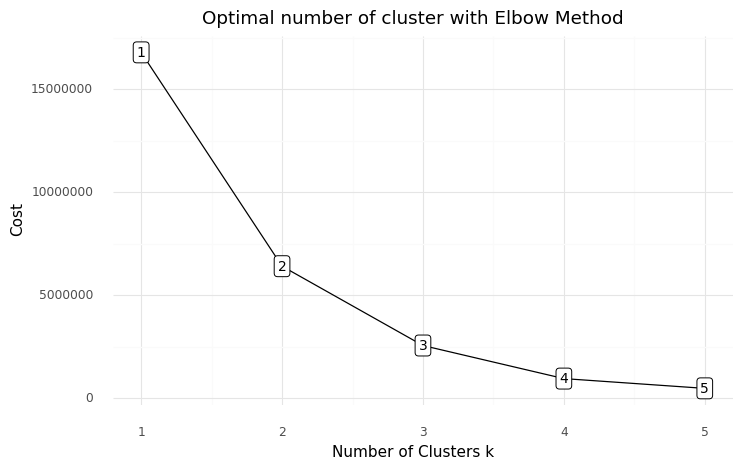

<ggplot: (8731846557629)>

In [55]:
# Choose optimal K using Elbow method
cost = []
for cluster in range(1, 10):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, len(cost)+1), 'Cost':cost})
# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

Fromt he graph above, using the elbow method, I opted for choosing the number of clusters `k=2`.

In [56]:
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 2, init = 'Huang', random_state = 0)
kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0], dtype=uint16)

In [57]:
# Add the cluster to the dataframe
df['Cluster Labels'] = kprototype.labels_
df['Segment'] = df['Cluster Labels'].map({0:'First', 1:'Second', 2:'Third', 3:'Fourth'})
# Order the cluster
df['Segment'] = df['Segment'].astype('category')
# df['Segment'] = df['Segment'].cat.reorder_categories(['First','Second','Third','Fourth'])
df['Segment'] = df['Segment'].cat.reorder_categories(['First','Second'])

In [58]:
df

,state,age,recency,expense_frequency_pondered,income_frequency_pondered,transfer_frequency_x_pondered,expense_ammount_pondered,income_ammount_pondered,transfer_ammount_x_pondered,food_and_drink_frequency_pondered,not_informed_frequency_pondered,payment_frequency_pondered,recreation_frequency_pondered,shops_frequency_pondered,transfer_frequency_y_pondered,travel_frequency_pondered,food_and_drink_ammount_pondered,not_informed_ammount_pondered,payment_ammount_pondered,recreation_ammount_pondered,shops_ammount_pondered,transfer_ammount_y_pondered,travel_ammount_pondered,Cluster Labels,Segment
id,,,,,,,,,,,,,,,,,,,,,,,,,
ad7226ed-2d26-45fd-ab37-c3823cd5db0c,NY,34.103,0,0.168,0.033,0.000,-3.924,16.667,0.000,0.100,0.000,0.000,0.000,0.000,0.000,0.101,-3.524,0.000,0.000,0.000,0.000,0.000,16.267,0,First
696fd855-cd7f-438d-80b0-b278037f9ca8,CA,32.526,0,0.167,0.292,0.000,-21.743,813.609,0.000,0.000,0.458,0.000,0.000,0.000,0.000,0.000,0.000,791.866,0.000,0.000,0.000,0.000,0.000,1,Second
b486d0b6-c135-4da4-8418-7040ddd823e9,IL,33.342,0,0.200,0.350,0.000,-26.091,976.331,0.000,0.000,0.550,0.000,0.000,0.000,0.000,0.000,0.000,950.239,0.000,0.000,0.000,0.000,0.000,1,Second
42e17652-ce67-4df9-b613-21563fdef1b3,NY,29.651,0,0.737,0.068,0.000,-281.580,34.247,0.000,0.337,0.000,0.066,0.068,0.066,0.000,0.268,-72.995,0.000,-136.668,-5.377,-32.877,0.000,0.584,0,First
3e7f8b0c-9111-466c-9a40-265f14019f13,VA,39.288,0,0.000,0.500,0.000,0.000,0.044,0.000,0.000,0.500,0.000,0.000,0.000,0.000,0.000,0.000,0.044,0.000,0.000,0.000,0.000,0.000,0,First
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3a386ba5-e8ba-47e9-97f5-1ad4c53442ec,CT,31.546,0,1.291,0.203,0.101,-1112.831,50.079,-2.517,0.495,0.005,0.200,0.099,0.099,0.299,0.396,-109.160,0.001,-208.972,-7.797,-49.664,-689.184,-0.493,0,First
e9a5ee9a-e46c-43c9-9f68-a8c901f82ff4,NY,35.140,0,0.372,0.033,0.000,-146.931,16.529,0.000,0.168,0.000,0.034,0.033,0.034,0.000,0.135,-37.930,0.000,-71.574,-2.595,-17.218,0.000,-1.085,0,First
1ef60c75-570f-4b2d-8616-96098a998367,NY,21.462,11,0.069,0.000,0.000,-406.250,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.069,0.000,0.000,0.000,0.000,0.000,0.000,-406.250,0.000,0,First


In [59]:
df.columns

Index(['state', 'age', 'recency', 'expense_frequency_pondered',
       'income_frequency_pondered', 'transfer_frequency_x_pondered',
       'expense_ammount_pondered', 'income_ammount_pondered',
       'transfer_ammount_x_pondered', 'food_and_drink_frequency_pondered',
       'not_informed_frequency_pondered', 'payment_frequency_pondered',
       'recreation_frequency_pondered', 'shops_frequency_pondered',
       'transfer_frequency_y_pondered', 'travel_frequency_pondered',
       'food_and_drink_ammount_pondered', 'not_informed_ammount_pondered',
       'payment_ammount_pondered', 'recreation_ammount_pondered',
       'shops_ammount_pondered', 'transfer_ammount_y_pondered',
       'travel_ammount_pondered', 'Cluster Labels', 'Segment'],
      dtype='object')

In [60]:
# Cluster interpretation
groups = df.rename(columns = {'Cluster Labels':'Total'}, inplace = True)
groups = df.groupby('Segment').agg(
    {
        'Total':'count',
        'state': lambda x: x.value_counts().index[0],
        'age': 'mean',
        'recency': 'mean',
        'expense_frequency_pondered': 'mean',
        'income_frequency_pondered': 'mean',
        'transfer_frequency_x_pondered': 'mean',
        'expense_ammount_pondered': 'mean',
        'income_ammount_pondered': 'mean',
        'transfer_ammount_x_pondered': 'mean',
        'food_and_drink_frequency_pondered': 'mean',
        'not_informed_frequency_pondered': 'mean',
        'payment_frequency_pondered': 'mean',
        'recreation_frequency_pondered': 'mean',
        'shops_frequency_pondered': 'mean',
        'transfer_frequency_y_pondered': 'mean',
        'travel_frequency_pondered': 'mean',
        'food_and_drink_ammount_pondered': 'mean',
        'not_informed_ammount_pondered': 'mean',
        'payment_ammount_pondered': 'mean',
        'recreation_ammount_pondered': 'mean',
        'shops_ammount_pondered': 'mean',
        'transfer_ammount_y_pondered': 'mean',
        'travel_ammount_pondered': 'mean'
    }
).reset_index()

In [61]:
groups

,Segment,Total,state,age,recency,expense_frequency_pondered,income_frequency_pondered,transfer_frequency_x_pondered,expense_ammount_pondered,income_ammount_pondered,transfer_ammount_x_pondered,food_and_drink_frequency_pondered,not_informed_frequency_pondered,payment_frequency_pondered,recreation_frequency_pondered,shops_frequency_pondered,transfer_frequency_y_pondered,travel_frequency_pondered,food_and_drink_ammount_pondered,not_informed_ammount_pondered,payment_ammount_pondered,recreation_ammount_pondered,shops_ammount_pondered,transfer_ammount_y_pondered,travel_ammount_pondered
0,First,75,NY,32.283,0.160,0.071,0.436,0.005,-53.512,5.925,-0.113,0.030,0.425,0.009,0.005,0.005,0.013,0.025,-5.609,2.560,-10.338,-0.385,-2.460,-32.303,0.834
1,Second,5,NY,28.951,0.000,0.471,0.464,0.041,-252.763,1063.002,-1.014,0.100,0.615,0.061,0.020,0.020,0.080,0.080,-22.009,1024.432,-42.640,-1.572,-10.014,-138.873,-0.099


In [62]:
groups.groupby('Segment').describe()

Total                           ... travel_ammount_pondered                            
        count   mean std    min    25%  ...                     min    25%    50%    75%    max
Segment                                 ...                                                    
First   1.000 75.000 nan 75.000 75.000  ...                   0.834  0.834  0.834  0.834  0.834
Second  1.000  5.000 nan  5.000  5.000  ...                  -0.099 -0.099 -0.099 -0.099 -0.099

[2 rows x 184 columns]

Now we'll do the same analysis without the pondered values.

In [79]:
users_analytical = users.merge(df[['Total','Segment']].reset_index(), left_on='id', right_on='id')

In [80]:
users_analytical = users_analytical[users_analytical.columns[~users_analytical.columns.str.contains('pondered')]]

In [81]:
users_analytical.drop(['days_delta'], axis=1, inplace=True)

In [85]:
# Cluster interpretation
# groups_not_pondered = users_analytical.rename(columns = {'Cluster Labels':'Total'}, inplace = True)
groups_not_pondered = users_analytical.groupby('Segment').agg(
    {
        'Total':'count',
        'state': lambda x: x.value_counts().index[0],
        'age': 'mean',
        'recency': 'mean',
        'expense_frequency': 'sum',
        'income_frequency': 'sum',
        'transfer_frequency_x': 'sum',
        'expense_ammount': 'sum',
        'income_ammount': 'sum',
        'transfer_ammount_x': 'sum',
        'food_and_drink_frequency': 'sum',
        'not_informed_frequency': 'sum',
        'payment_frequency': 'sum',
        'recreation_frequency': 'sum',
        'shops_frequency': 'sum',
        'transfer_frequency_y': 'sum',
        'travel_frequency': 'sum',
        'food_and_drink_ammount': 'sum',
        'not_informed_ammount': 'sum',
        'payment_ammount': 'sum',
        'recreation_ammount': 'sum',
        'shops_ammount': 'sum',
        'transfer_ammount_y': 'sum',
        'travel_ammount': 'sum'
    }
).reset_index()

In [86]:
groups_not_pondered

,Segment,Total,state,age,recency,expense_frequency,income_frequency,transfer_frequency_x,expense_ammount,income_ammount,transfer_ammount_x,food_and_drink_frequency,not_informed_frequency,payment_frequency,recreation_frequency,shops_frequency,transfer_frequency_y,travel_frequency,food_and_drink_ammount,not_informed_ammount,payment_ammount,recreation_ammount,shops_ammount,transfer_ammount_y,travel_ammount
0,First,75,NY,32.283,0.160,3910.000,1109.000,248.000,-2949947.320,200560.150,-6200.000,1644.000,498.000,519.000,270.000,271.000,692.000,1373.000,-308908.640,15534.690,-569473.500,-21195.000,-135500.000,-1781724.540,45679.820
1,Second,5,NY,28.951,0.000,1730.000,1696.000,150.000,-932615.970,3878962.380,-3750.000,369.000,2244.000,224.000,74.000,74.000,296.000,295.000,-81324.020,3737789.400,-157559.000,-5809.000,-37000.000,-513133.880,-367.090


In therms of the variables (features) that were created, this group has a very similar behavior, hence the algorithm grouped most users on the First group. This may be an indication that we need more data in order to achieve better results.

To analyze the segments, instead of calculating some central measure like the mean, I used the sum of each category, taking into account the different time deltas present in the transactions data.

Now to the information that we can get from the formed segments. The users from the first segment had a total income on the period of the analysis of \\$ 200560.15 and their expenses were way above their income, at \\$ 2949947.32. For interpretations purposes, we'll call this group as **Spenders**.

The second segment has the opposite behavior, their income on the period was \\$ 3878962.38 while their expense was \\$ 932615.97. For interpretation purposes, we'll call this group as **Savers**.

The Spenders had as their most frequent spent category Food and Drink, follow by Travel, while the Savers had the Not Informed category, followed by a balanced mix of Food and Drink, Payment, Transfer and Travel categories.

Any further consideration could lead to wrong interpretations again brought by the different time deltas on the transactions data.

As the last tought, here are the considerations I would try in order to improve this segmentation if I had more time or were on a real business case:

1. Ask the business coworkers for more data, if possible.
2. Spend more time with the business coworkers and adjust the analysis towards their needs.
3. Try some more feature engineering techniques, such as log-transform, and mixing and matching the data to come up with new features.
4. Try to implement a Principal Component Analysis (PCA) to get rid of noise. This could greatly improve the convergence of the clustering algorithm.
5. Try to scale all the data to the same range (*e.g.* scale all the numeric data to fit betwen the [-1,1] interval), this could also improve the clustering algorithm.